In [1]:
#importing packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [2]:
# Load Dataset
def load_dataset():
    dataset_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
    column_names = [
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
    ]
    data = pd.read_csv(dataset_path, names=column_names, na_values='?')
    return data

In [3]:
# Preprocess Dataset
def preprocess_data(data):
    # Handle missing values
    data.dropna(inplace=True)

    # Convert target to binary classification (0 for no heart disease, 1 for heart disease)
    data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)

    # Split features and target
    X = data.drop('target', axis=1)
    y = data['target']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

In [4]:
# Train and Evaluate Models
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    models = {
        "Logistic Regression": LogisticRegression(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "SVM": SVC(kernel='linear', probability=True),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Naive Bayes": GaussianNB(),
        "Neural Network": Sequential([
            Input(shape=(X_train.shape[1],)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "Voting Classifier": VotingClassifier(estimators=[
            ('lr', LogisticRegression()), 
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)), 
            ('gb', GradientBoostingClassifier())
        ], voting='soft')
    }

    metrics = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
    results = pd.DataFrame(columns=["Model"] + metrics)
    trained_models = {}

    for name, model in models.items():
        if name == "Neural Network":
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0)
            y_pred = (model.predict(X_test) > 0.5).astype("int32")
            y_proba = model.predict(X_test).ravel()
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        new_row = pd.DataFrame({
            "Model": [name],
            "Accuracy": [accuracy],
            "Precision": [precision],
            "Recall": [recall],
            "F1-score": [f1],
            "ROC-AUC": [roc_auc]
        })

        results = pd.concat([results, new_row], ignore_index=True)
        trained_models[name] = model

        print(f'{name} Accuracy: {accuracy * 100:.2f}%')
        print(f'{name} Precision: {precision:.2f}')
        print(f'{name} Recall: {recall:.2f}')
        print(f'{name} F1-score: {f1:.2f}')
        print(f'{name} ROC-AUC: {roc_auc:.2f}')
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return results, trained_models

In [5]:
# Plot ROC Curves
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for name, model in models.items():
        if name == "Neural Network":
            y_proba = model.predict(X_test).ravel()
        else:
            y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc_score(y_test, y_proba):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
# Comparison Plot
def plot_comparison(results):
    results.set_index("Model", inplace=True)
    results.plot(kind="bar", figsize=(14, 8))
    plt.title("Model Comparison")
    plt.ylabel("Score")
    plt.show()

Logistic Regression Accuracy: 88.89%
Logistic Regression Precision: 0.90
Logistic Regression Recall: 0.85
Logistic Regression F1-score: 0.88
Logistic Regression ROC-AUC: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        49
           1       0.90      0.85      0.88        41

    accuracy                           0.89        90
   macro avg       0.89      0.89      0.89        90
weighted avg       0.89      0.89      0.89        90



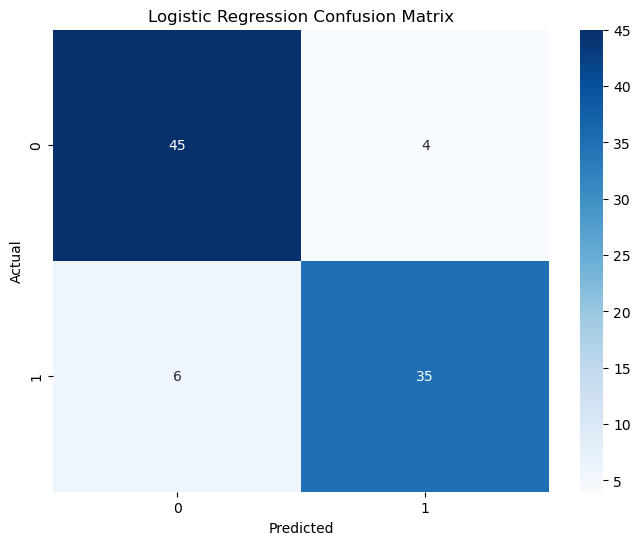

Decision Tree Accuracy: 77.78%
Decision Tree Precision: 0.74
Decision Tree Recall: 0.78
Decision Tree F1-score: 0.76
Decision Tree ROC-AUC: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        49
           1       0.74      0.78      0.76        41

    accuracy                           0.78        90
   macro avg       0.78      0.78      0.78        90
weighted avg       0.78      0.78      0.78        90



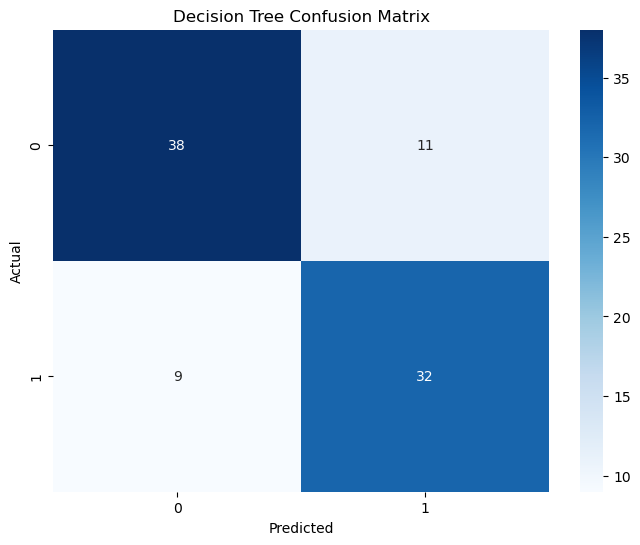

Random Forest Accuracy: 85.56%
Random Forest Precision: 0.85
Random Forest Recall: 0.83
Random Forest F1-score: 0.84
Random Forest ROC-AUC: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        49
           1       0.85      0.83      0.84        41

    accuracy                           0.86        90
   macro avg       0.85      0.85      0.85        90
weighted avg       0.86      0.86      0.86        90



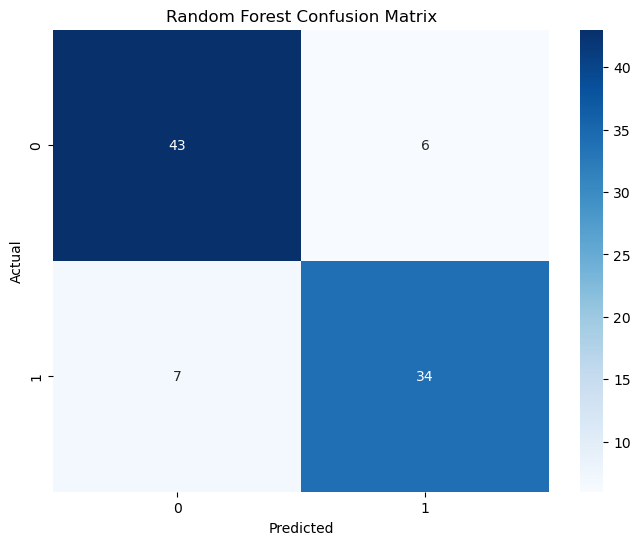

Gradient Boosting Accuracy: 83.33%
Gradient Boosting Precision: 0.81
Gradient Boosting Recall: 0.83
Gradient Boosting F1-score: 0.82
Gradient Boosting ROC-AUC: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        49
           1       0.81      0.83      0.82        41

    accuracy                           0.83        90
   macro avg       0.83      0.83      0.83        90
weighted avg       0.83      0.83      0.83        90



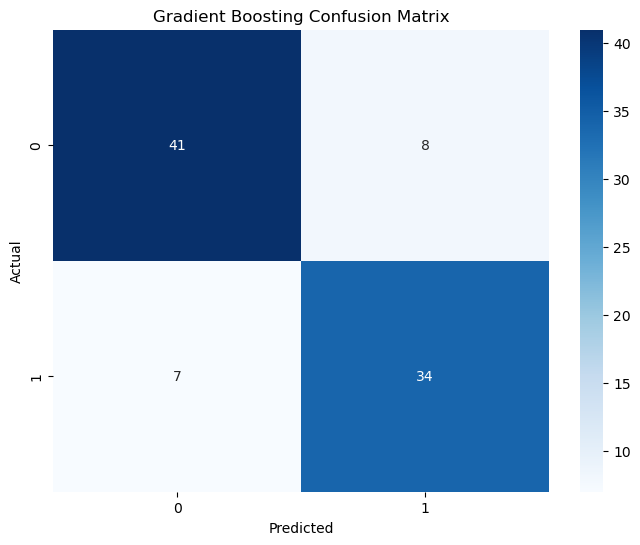

XGBoost Accuracy: 82.22%
XGBoost Precision: 0.82
XGBoost Recall: 0.78
XGBoost F1-score: 0.80
XGBoost ROC-AUC: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        49
           1       0.82      0.78      0.80        41

    accuracy                           0.82        90
   macro avg       0.82      0.82      0.82        90
weighted avg       0.82      0.82      0.82        90



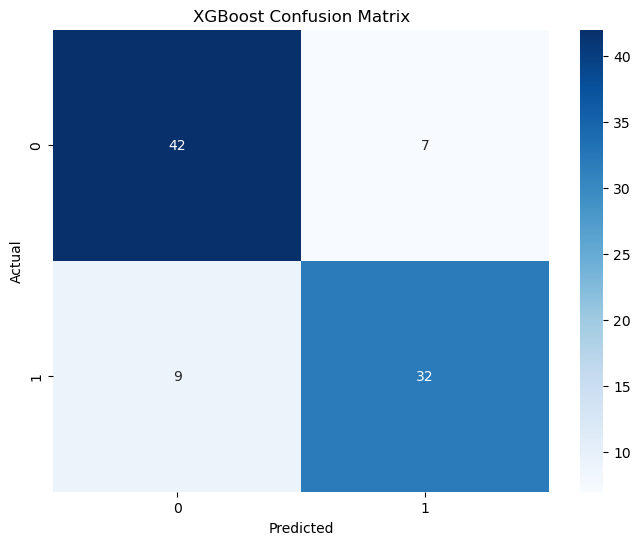

SVM Accuracy: 86.67%
SVM Precision: 0.89
SVM Recall: 0.80
SVM F1-score: 0.85
SVM ROC-AUC: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        49
           1       0.89      0.80      0.85        41

    accuracy                           0.87        90
   macro avg       0.87      0.86      0.86        90
weighted avg       0.87      0.87      0.87        90



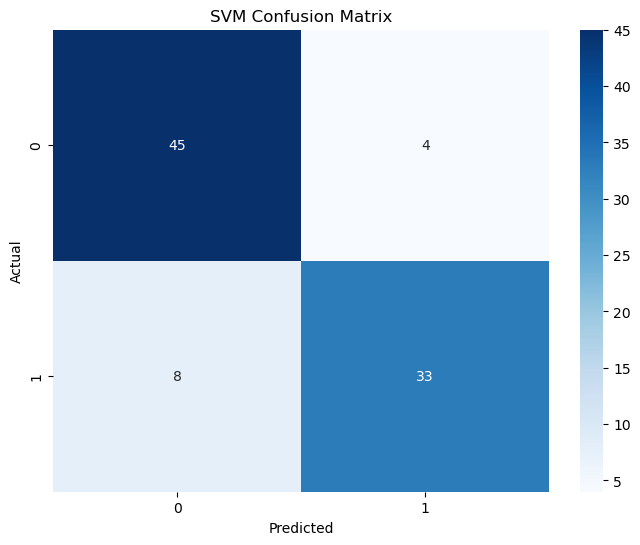

K-Nearest Neighbors Accuracy: 83.33%
K-Nearest Neighbors Precision: 0.88
K-Nearest Neighbors Recall: 0.73
K-Nearest Neighbors F1-score: 0.80
K-Nearest Neighbors ROC-AUC: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        49
           1       0.88      0.73      0.80        41

    accuracy                           0.83        90
   macro avg       0.84      0.83      0.83        90
weighted avg       0.84      0.83      0.83        90



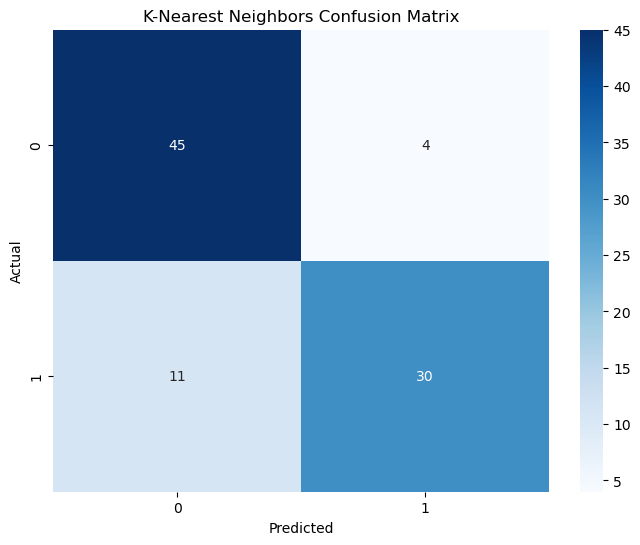

Naive Bayes Accuracy: 90.00%
Naive Bayes Precision: 0.92
Naive Bayes Recall: 0.85
Naive Bayes F1-score: 0.89
Naive Bayes ROC-AUC: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        49
           1       0.92      0.85      0.89        41

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.90      0.90      0.90        90



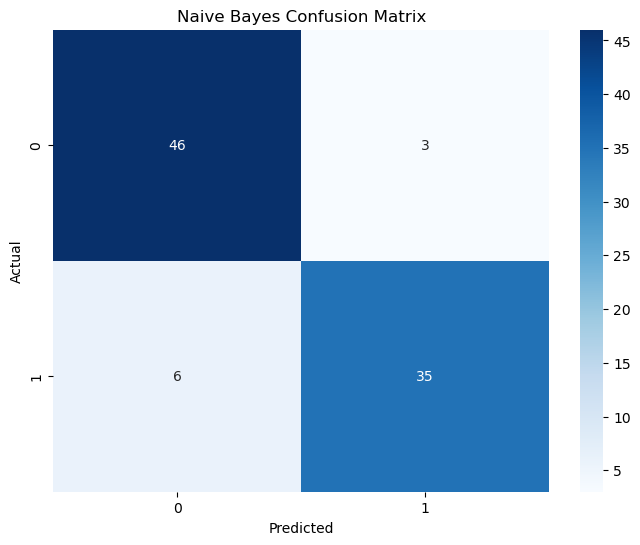

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Neural Network Accuracy: 84.44%
Neural Network Precision: 0.83
Neural Network Recall: 0.83
Neural Network F1-score: 0.83
Neural Network ROC-AUC: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        49
           1       0.83      0.83      0.83        41

    accuracy                           0.84        90
   macro avg       0.84      0.84      0.84        90
weighted avg       0.84      0.84      0.84        90



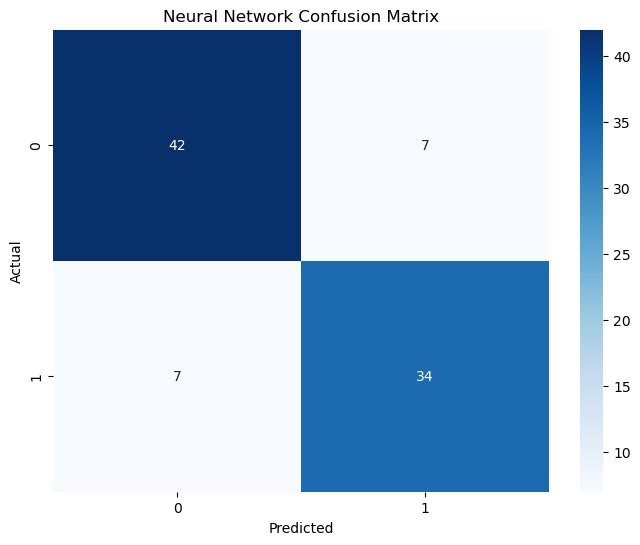

Voting Classifier Accuracy: 85.56%
Voting Classifier Precision: 0.87
Voting Classifier Recall: 0.80
Voting Classifier F1-score: 0.84
Voting Classifier ROC-AUC: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87        49
           1       0.87      0.80      0.84        41

    accuracy                           0.86        90
   macro avg       0.86      0.85      0.85        90
weighted avg       0.86      0.86      0.85        90



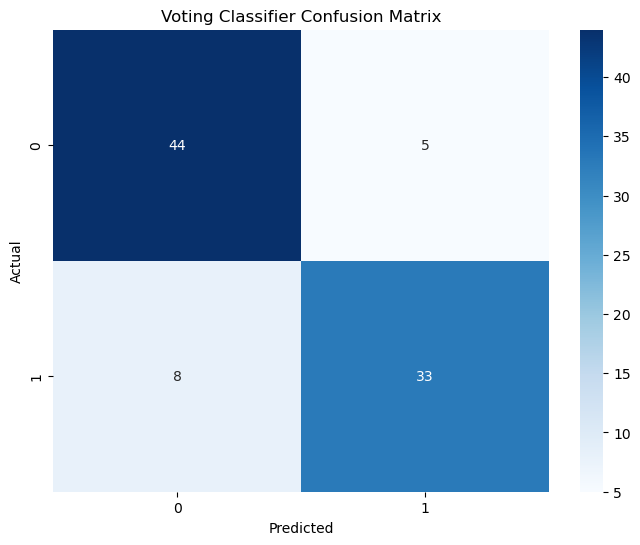

In [7]:
# Main Function
if __name__ == "__main__":
    data = load_dataset()
    X, y = preprocess_data(data)
    results, trained_models = train_and_evaluate(X, y)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


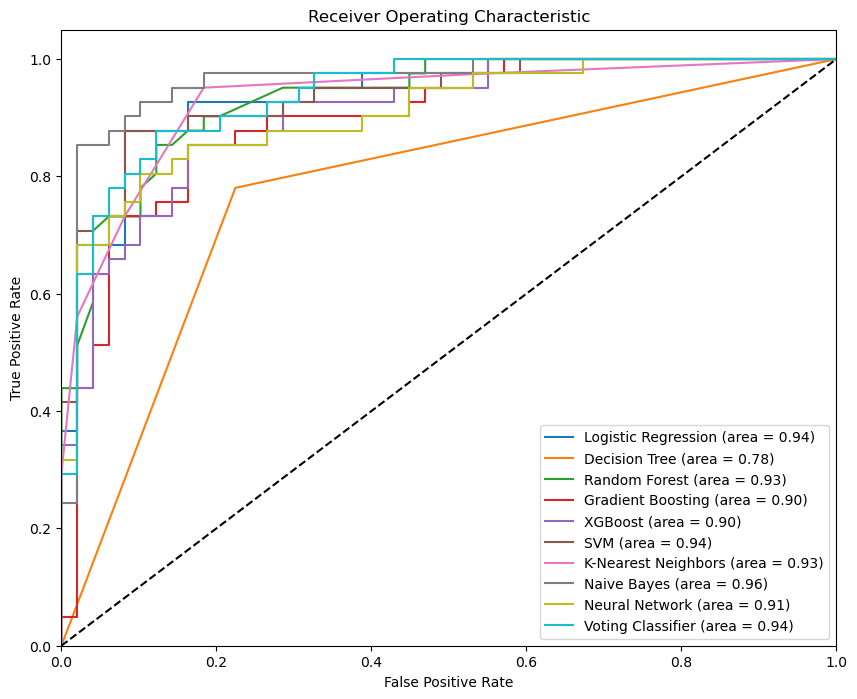

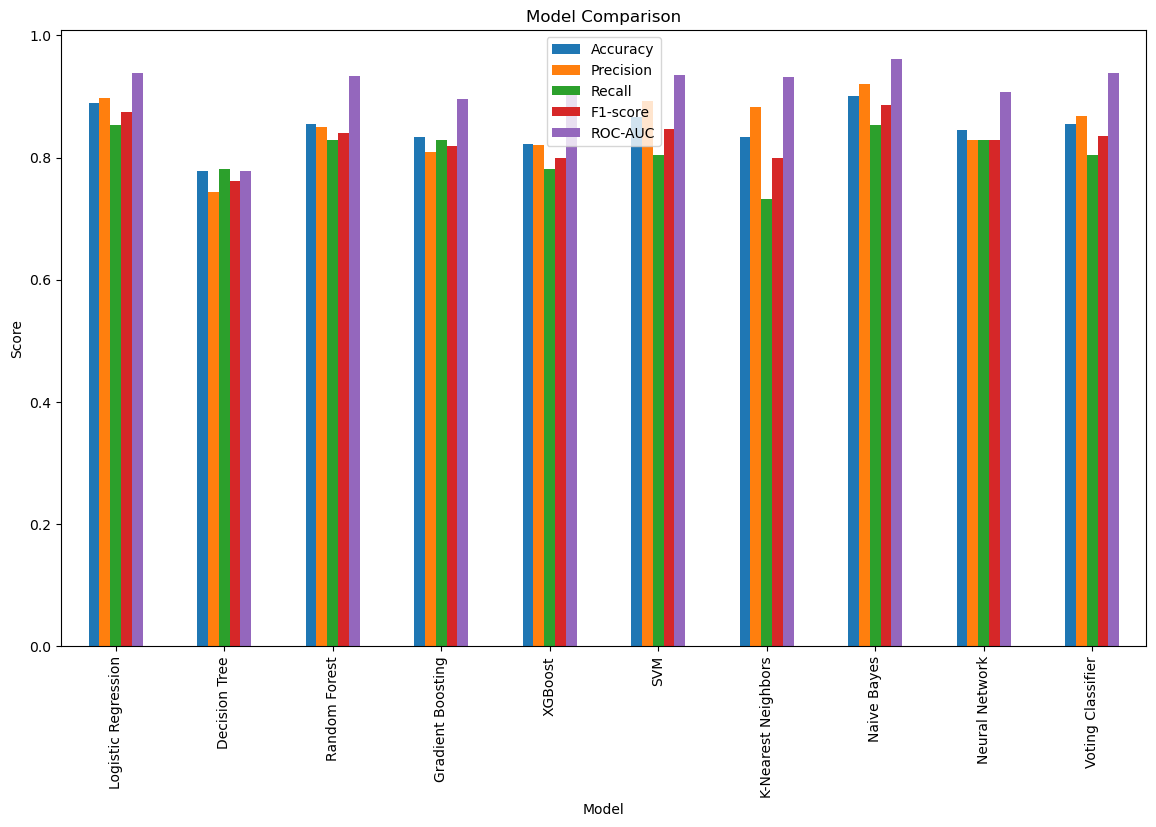

In [9]:
    # Split again for ROC curves as the models are already trained
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    plot_roc_curves(trained_models, X_test, y_test)
    plot_comparison(results)